<a href="https://colab.research.google.com/github/koreahong/-/blob/main/%EB%B9%85%EB%B6%84%EA%B8%B0_%EC%8B%A4%EA%B8%B0_%EC%98%88%EC%A0%9C%ED%92%80%EC%9D%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#한글폰트 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
  #구글 들라이브 연동
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#기본패키지 실행
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#데이터 수집

In [ ]:
x_train = pd.read_csv("/content/drive/MyDrive/데이터분석 공부/data/X_train.csv", encoding='euc-kr')
y_train = pd.read_csv("/content/drive/MyDrive/데이터분석 공부/data/y_train.csv", encoding='euc-kr')
x_test = pd.read_csv("/content/drive/MyDrive/데이터분석 공부/data/X_test.csv", encoding='euc-kr')

In [ ]:
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()
x_test_copy = x_test.copy()

#데이터 전처리

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   int64  
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 273.6+ KB


### null 값 확인

### EDA 후 바로 적용

In [ ]:
x_test_copy = x_test_copy.fillna(0)
x_train_copy = x_train_copy.fillna(0)

###EDA 전 데이터 확인

In [ ]:
x_train.isnull().sum()

cust_id       0
총구매액          0
최대구매액         0
환불금액       2295
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [ ]:
x_test.isnull().sum()

cust_id       0
총구매액          0
최대구매액         0
환불금액       1611
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

환불금액 피쳐 처리
1. 환불금액은 train, test 모두 과반 이상의 널값을 가지고 있다. 환불금액 특성상 평균값이나 대체값을 넣기에는 부적절함으로 피처를 삭제
2. gender와 확인 후 사용여부 결정



#### 성별 환불금액 그래프

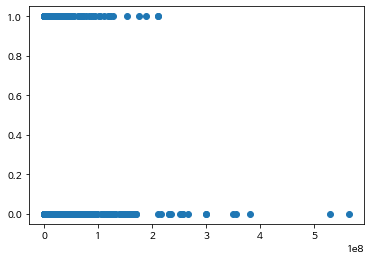

In [ ]:
plt.scatter(x_train_copy['환불금액'],y_train_copy['gender'])

In [ ]:
#성별 환불여부 카운트
pd.DataFrame([x_train_copy['환불금액'], y_train_copy['gender']]).T.groupby('gender').agg(['size', 'mean', 'std', 'min', 'max','count'])



환불금액                                                        
        size          mean           std      min          max count
gender                                                              
0.0     2184  2.616227e+07  5.117071e+07  18000.0  563753000.0   915
1.0     1316  1.750266e+07  3.236366e+07   5600.0  210771400.0   290

- 성별간에 환불여부의 숫자에서 유의미한 차이가 보인다
- 단, 환불금액이나 차이등에서 뚜렷한 차이가 없음으로 환불을 했으면 1, 없으면 0으로 대체하여 사용

In [ ]:
#환불을 했으면 1, 없으면 0으로 대체하여 사용
x_train_copy['환불금액'] = x_train_copy['환불금액'].apply(lambda x: 1 if x > 0 else 0)
x_test_copy['환불금액'] = x_test_copy['환불금액'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
x_train_copy['환불금액']= x_train_copy['환불금액'].astype('object')

In [ ]:
##환불금액이 무의미이면 삭제
# c  x_test_copy.drop('환불금액', inplace=True, axis=1)
# x_train_copy.drop('환불금액', inplace=True, axis=1)

### 불필요한 컬럼삭제

In [ ]:
#cust_id 삭제
x_test_copy.drop('cust_id', inplace=True, axis=1)
x_train_copy.drop('cust_id', inplace=True, axis=1)
y_train_copy.drop('cust_id', inplace=True, axis=1)


### 분포확인

- 분포가 한쪽으로 치우쳐져 있음으로 로그변환 및 정규화 수행
- 로지스틱 회귀를 사용할 것임으로 정규화 진행

In [ ]:
x_train_copy['총구매액'].hist()

In [ ]:
x_train_copy.hist()

1 총구매액
2 최대구매액
3 주구매상품
4 주구매지점
5 내점일수
6 내점당구매건수
7 주말방문비율
8 구매주기


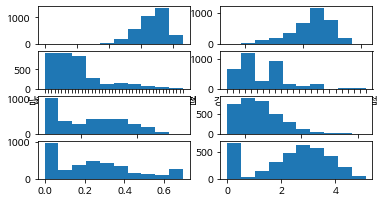

In [ ]:
for num, data in zip(list(range(1, 11)), x_train_copy.columns[1:]):
    print(num, data)
    plt.subplot(5, 2, num)
    plt.hist(x_train_copy[data])

In [ ]:
heat_col = list(set(x_train_copy.columns)-set(['주구매상품','주구매지점']))

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10,8))
plt.pcolor(x_train_copy[heat_col].corr())
plt.xticks(np.arange(0.5, len(heat_col), 1), heat_col)

plt.yticks(np.arange(0.5, len(heat_col), 1), heat_col)
plt.colorbar()

## 이상치 확인

In [ ]:
for i in heat_col:
  q1, q3 = np.percentile(x_train_copy[i].values,[25,75])
  iqr = q3-q1
  lower_bound = q1 - (iqr * 1.5)
  upper_bound = q3 + (iqr * 1.5)

  outlier_index = x_train_copy[(x_train_copy[i] > upper_bound) | (x_train_copy[i] < lower_bound)].index
  x_train_copy.drop(outlier_index, axis=0, inplace= True)
  x_train_copy.reset_index(drop=True, inplace=True)
  y_train_copy.drop(outlier_index, axis=0, inplace= True)
  y_train_copy.reset_index(drop=True, inplace=True)

## 원핫 인코딩

In [ ]:
x_train_copy['환불여부'] = x_train_copy['환불금액']
x_test_copy['환불여부'] = x_test_copy['환불금액']
x_train_copy.drop('환불금액', axis=1,inplace=True)
x_test_copy.drop('환불금액', axis=1,inplace=True)

In [ ]:
x_train_copy.drop('주구매지점', axis=1,inplace=True)
x_test_copy.drop('주구매지점', axis=1,inplace=True)

In [ ]:
all_data = pd.concat((x_train_copy,x_test_copy))

for column in all_data.select_dtypes(include=[np.object]).columns:
    x_train_copy[column] = pd.Categorical(x_train_copy[column], categories = all_data[column].unique()) 
    x_test_copy[column] = pd.Categorical(x_test_copy[column], categories = all_data[column].unique()) 

In [ ]:
x_train_copy = pd.get_dummies(x_train_copy)
x_test_copy = pd.get_dummies(x_test_copy)

### 로그변환

In [ ]:
for i in x_train_copy.columns[:6]:
  x_train_copy[i] = np.log1p(x_train_copy[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler as SS


scaler = SS()

data_scaled = scaler.fit_transform(x_train_copy.iloc[:,:7])

In [ ]:
x_train_copy = pd.concat([pd.DataFrame(data_scaled), x_train_copy.iloc[:,7:]],axis = 1)

### 데이터셋 나누기
- 트레이닝 데이터 -> 학습, 테스트로 나누기

In [ ]:
from sklearn.model_selection import train_test_split

x_train_renew, x_text_renew, y_train_renew, y_test_renew = train_test_split(x_train_copy, y_train_copy, test_size=0.2, random_state=28)

#모델 생성

### 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV as GS
from sklearn.ensemble import RandomForestClassifier as RF
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgb

In [ ]:
lr_clf = LogisticRegression()

params = {
    'max_iter' : [1000,10000],
    'C' : [0.1,0.5,1,5,10],
    'penalty' : ['l1','l2'],
    'solver' : ['liblinear'],
    'verbose' : [0],
}
grid_lr = GS(lr_clf, param_grid=params, cv=3)
grid_lr.fit(x_train_renew, y_train_renew.values.ravel())

In [ ]:
grid_lr_pred_proba = grid_rf.predict_proba(x_text_renew)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, precision_score,recall_score,confusion_matrix,roc_auc_score

In [ ]:


thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.60]
for custom_threshold in thresholds:
  binarizer = Binarizer(threshold=custom_threshold).fit(grid_lr_pred_proba)
  custom_predict = binarizer.transform(grid_lr_pred_proba[:, 1].reshape(-1,1))
  print(custom_threshold, roc_auc_score(y_test_renew, custom_predict))
  

0.3 0.5905130389719897
0.4 0.5917119744227103
0.45 0.5831261912499671
0.5 0.5533328648848056
0.55 0.5129950549402289
0.6 0.5019455252918288


### 랜덤포레스트

In [ ]:
rf_clf = RF()
params = {
    'min_samples_split' : [3,4,5,6,7],
    'max_depth' : [3,5,10,50,100,1000],
    'verbose' : [1],
  }
grid_rf = GS(rf_clf, param_grid=params, cv=3, scoring='roc_auc')
grid_rf.fit(x_train_renew, y_train_renew)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
from sklearn.model_selection import GridSearchCV as GS

array([1, 1, 1, ..., 1, 1, 1])

### xgboost

In [ ]:
xgb_clf = xgb()
params = {
    'learning_rate' : (0.1, 1),
    'max_depth' : [3,5,10,50,100,1000],
    'verbose' : [1],
    'early_stopping_rounds' :[100],
    'eval_metric' : ['logloss'],
    'n_estimator' : [100,400,1000]
  }
grid_xgb = GS(xgb_clf, param_grid=params, cv=3, scoring='roc_auc')
grid_xgb.fit(x_train_renew, y_train_renew.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'early_stopping_rounds': [100],
                         'eval_metric': ['logloss'], 'learning_rate': (0.1, 1),
                         'max_depth': [3

###lightGBM

In [ ]:
lgb_clr = lgb()
params = {
    'learning_rate' : (0.1, 1),
    'max_depth' : [3,5,10,50,100,1000],
    'verbose' : [1],
    'early_stopping_rounds' :[100],
    'eval_metric' : ['logloss'],
    'n_estimator' : [100,400,1000],
    'boosting' : ['rf','gbdt']
  }
grid_lgb = GS(xgb_clf, param_grid=params, cv=3, scoring='roc_auc')
grid_lgb.fit(x_train_renew, y_train_renew.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...e, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'boosting': ['rf', 'gbdt'],
                         'early_stopping_rounds': [100],
                         'eval_metric': ['logloss'], 'learning_rate': (0.1, 1),
    

#모델평가

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pd.DataFrame(grid_lr.cv_results_)[['mean_test_score','rank_test_score','params']].sort_values('rank_test_score')

In [ ]:
pd.DataFrame(grid_rf.cv_results_)[['mean_test_score','rank_test_score','params']].sort_values('rank_test_score')

In [ ]:
pd.DataFrame(grid_xgb.cv_results_)[['mean_test_score','rank_test_score','params']].sort_values('rank_test_score')

In [ ]:
pd.DataFrame(grid_lgb.cv_results_)[['mean_test_score','rank_test_score','params']].sort_values('rank_test_score')

#스태킹 모델

In [ ]:
from sklearn.model_selection import KFold

def get_stacking_base_datasets(model, x_train, y_train, x_test, folds):

  kf = KFold(n_splits=folds, shuffle=False, random_state=28)

  train_fold_pred = np.zeros((x_train.shape[0],1))
  test_pred = np.zeros((x_test.shape[0], folds))

  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(x_train)):

    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[valid_index]

    model.fit(x_tr, y_tr)

    train_fold_pred[valid_index, :] = model.predict(x_te).reshape(-1,1)

    test_pred[:, folder_counter] = model.predict(x_test)

  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [ ]:
rf_train, rf_test = get_stacking_base_datasets(grid_rf, x_train_renew, y_train_renew.values.ravel(), x_text_renew, 7)

In [ ]:
xgb_train, xgb_test = get_stacking_base_datasets(grid_xgb, x_train_renew.values, y_train_renew.values.ravel(), x_text_renew.values, 7)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GridSearchCV model 시작


In [ ]:
lgb_train, lgb_test = get_stacking_base_datasets(grid_lgb, x_train_renew.values, y_train_renew.values.ravel(), x_text_renew.values, 7)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GridSearchCV model 시작


In [ ]:
stack_final_x_train = np.concatenate((rf_train, xgb_train, lgb_train), axis = 1)
stack_final_x_test = np.concatenate((rf_test, xgb_test, lgb_test), axis = 1)

In [ ]:
## 최종모델 로지스틱 회귀
lr_clf = LogisticRegression()

params = {
    'max_iter' : [1000,10000],
    'C' : [0.1,0.5,1,5,10],
    'penalty' : ['l1','l2'],
    'solver' : ['liblinear'],
    'verbose' : [0],
}
grid_lr = GS(lr_clf, param_grid=params, cv=3)
grid_lr.fit(stack_final_x_train, y_train_renew.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'max_iter': [1000, 10000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
result = pd.DataFrame(grid_lr.predict_proba(stack_final_x_train)[:,-1])
result.to_csv("/content/drive/MyDrive/데이터분석 공부/data/result.csv", encoding='euc-kr'))